<a href="https://colab.research.google.com/github/M-Awwab-Khan/Dog-vs-Cat-Classification-Transfer-Learning/blob/main/Dog_vs_Cat_Classification_Mobilenet_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Dependencies

In [ ]:
!pip install tf-keras==2.16.0

In [ ]:
!pip install tensorflow==2.16.1

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tf_keras as keras
from PIL import Image
from google.colab.patches import cv2_imshow
import matplotlib.image as mpimg
import tensorflow_hub as hub
import tensorflow as tf

# Loading the Data

In [3]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('key')
os.environ["KAGGLE_USERNAME"] = userdata.get('username')

In [4]:
!kaggle competitions download -c dogs-vs-cats

 98% 795M/812M [00:03<00:00, 229MB/s]
100% 812M/812M [00:03<00:00, 272MB/s]


In [5]:
!unzip 'dogs-vs-cats.zip'

Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [ ]:
!unzip 'train.zip'

In [8]:
os.rename(r'/content/train/', r'/content/images/')

In [9]:
# counting the number of files in train folder
path, dirs, files = next(os.walk('/content/images'))
file_count = len(files)
print('Number of images: ', file_count)

Number of images:  25000


# Organizing images in train, test and validation directories

In [10]:
import os
import shutil
import random

# Define the directory containing the images
image_directory = "/content/images/"

# Create directories for train, validation, and test sets
train_dir = "/content/train/"
validation_dir = "/content/validation/"
test_dir = "/content/test/"

# Create subdirectories for cats and dogs in each set
for directory in [train_dir, validation_dir, test_dir]:
    os.makedirs(os.path.join(directory, "cat"), exist_ok=True)
    os.makedirs(os.path.join(directory, "dog"), exist_ok=True)

# List all image files
image_files = os.listdir(image_directory)

# Shuffle the list of image files
random.shuffle(image_files)

# Determine the number of images for each class in each set
num_images_per_class = len(image_files) // 2
num_train = num_images_per_class * 70 // 100
num_validation = num_images_per_class * 15 // 100
num_test = num_images_per_class - num_train - num_validation

# Track the number of cats and dogs in each set
train_cats = train_dogs = 0
validation_cats = validation_dogs = 0
test_cats = test_dogs = 0

# Organize images into train, validation, and test directories while maintaining balance
for i, file in enumerate(image_files):
    class_label = file.split('.')[0]
    if class_label == "cat":
        if train_cats < num_train:
            destination_dir = os.path.join(train_dir, "cat")
            train_cats += 1
        elif validation_cats < num_validation:
            destination_dir = os.path.join(validation_dir, "cat")
            validation_cats += 1
        else:
            destination_dir = os.path.join(test_dir, "cat")
            test_cats += 1
    elif class_label == "dog":
        if train_dogs < num_train:
            destination_dir = os.path.join(train_dir, "dog")
            train_dogs += 1
        elif validation_dogs < num_validation:
            destination_dir = os.path.join(validation_dir, "dog")
            validation_dogs += 1
        else:
            destination_dir = os.path.join(test_dir, "dog")
            test_dogs += 1
    shutil.copy(os.path.join(image_directory, file), os.path.join(destination_dir, file))

print("Files organized into directories successfully.")


Files organized into directories successfully.


In [11]:
print('train cats: ', len(os.listdir('/content/train/cat')))
print('train dogs: ', len(os.listdir('/content/train/dog')))
print('validation cats: ', len(os.listdir('/content/validation/cat')))
print('validation dogs: ', len(os.listdir('/content/validation/dog')))
print('test cats: ', len(os.listdir('/content/test/cat')))
print('test dogs: ', len(os.listdir('/content/test/dog')))

train cats:  8750
train dogs:  8750
validation cats:  1875
validation dogs:  1875
test cats:  1875
test dogs:  1875


# Training Data Preprocessing Pipeline

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directories for train, validation, and test data
train_dir = '/content/train/'
validation_dir = '/content/validation/'
test_dir = '/content/test/'

# Define image preprocessing and augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Define target image size and batch size
target_size = (224, 224)
batch_size = 32

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)


Found 17500 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.


# Using MobileNet V3 with Dense layer

In [19]:
# Load the MobileNet V3 model
mobilenet_v3_model = "https://www.kaggle.com/models/google/mobilenet-v3/TensorFlow2/large-075-224-feature-vector/1"
pretrained_model = hub.KerasLayer(mobilenet_v3_model, input_shape=(224,224,3), trainable=False)

# Define the number of classes
num_classes = 2

# Create the model
model = keras.models.Sequential([
    pretrained_model,
    keras.layers.Dense(num_classes)
])

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/5
546/546 [==============================] - 83s 111ms/step - loss: 0.0625 - accuracy: 0.9787 - val_loss: 0.0362 - val_accuracy: 0.9861
Epoch 2/5
546/546 [==============================] - 54s 97ms/step - loss: 0.0326 - accuracy: 0.9888 - val_loss: 0.0332 - val_accuracy: 0.9871
Epoch 3/5
546/546 [==============================] - 53s 96ms/step - loss: 0.0264 - accuracy: 0.9907 - val_loss: 0.0331 - val_accuracy: 0.9876
Epoch 4/5
546/546 [==============================] - 52s 96ms/step - loss: 0.0230 - accuracy: 0.9923 - val_loss: 0.0355 - val_accuracy: 0.9884
Epoch 5/5
546/546 [==============================] - 51s 94ms/step - loss: 0.0199 - accuracy: 0.9938 - val_loss: 0.0338 - val_accuracy: 0.9876
   6882/Unknown - 614s 89ms/step - loss: 0.0434 - accuracy: 0.9824

KeyboardInterrupt: 

# Model Evaluation

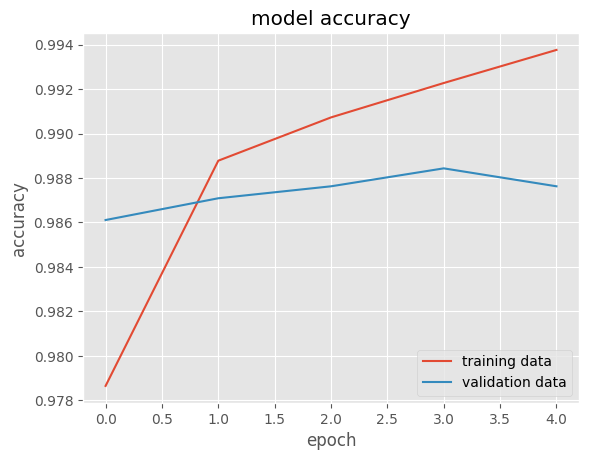

In [20]:
plt.style.use('ggplot')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend(['training data', 'validation data'], loc = 'lower right')

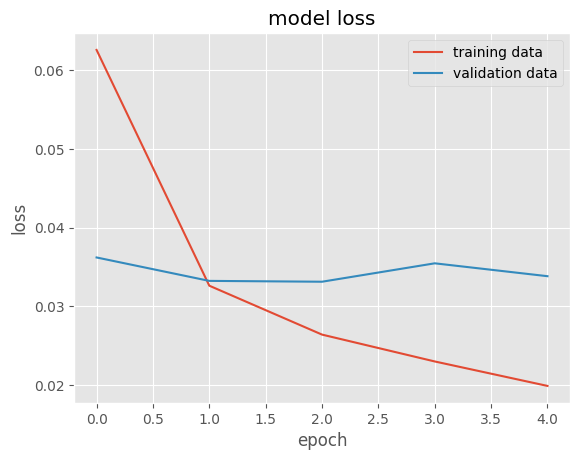

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['training data', 'validation data'], loc = 'upper right')

# Building Predictive Pipeline

In [22]:
# Define the target image size expected by the model
target_size = (224, 224)

# Load the trained model
# model = tf.keras.models.load_model("path/to/saved/model")

def preprocess_image(image_path):
    # Load the image using PIL
    image = Image.open(image_path)
    # Resize the image to match the target size expected by the model
    image = image.resize(target_size)
    # Convert the image to a NumPy array
    image_array = np.asarray(image)
    # Normalize the pixel values to [0, 1]
    image_array = image_array / 255.0
    # Expand the dimensions of the image array to match the expected input shape of the model
    image_array = np.expand_dims(image_array, axis=0)
    return image_array

def classify_image(image_path):
    # Preprocess the image
    preprocessed_image = preprocess_image(image_path)
    # Make predictions using the trained model
    predictions = model.predict(preprocessed_image)
    # Map prediction probabilities to class labels
    class_labels = ["cat", "dog"]
    probabilities = softmax(predictions[0])
    predicted_class = class_labels[np.argmax(probabilities)]
    confidence = np.max(probabilities) * 100
    return predicted_class, confidence

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

# Example usage
image_path = "/content/dog.jpg"
predicted_class, confidence = classify_image(image_path)
print("Predicted class:", predicted_class)
print("Confidence:", confidence)


1/1 [==============================] - 3s 3s/step
Predicted class: dog
Confidence: 99.91204738616943


# Saving the model

In [23]:
model.save('cat-vs-dog.keras')